# Agglomerative Hierachy Clustering on wine dataset

It is also known as the bottom-up approach or hierarchical agglomerative clustering (HAC). A structure that is more informative than the unstructured set of clusters returned by flat clustering. This clustering algorithm does not require us to prespecify the number of clusters. Bottom-up algorithms treat each data as a singleton cluster at the outset and then successively agglomerate pairs of clusters until all clusters have been merged into a single cluster that contains all data. 

reference: https://www.geeksforgeeks.org/hierarchical-clustering/

## Import Libraries

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

## Get Dataset
Reference : https://archive.ics.uci.edu/dataset/109/wine

In [2]:
%pip install ucimlrepo

from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
wine = fetch_ucirepo(id=109) 
  
# data (as pandas dataframes) 
X = wine.data.features 
y = wine.data.targets 
  
# metadata 
print(wine.metadata) 
  
# variable information 
print(wine.variables) 

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


{'uci_id': 109, 'name': 'Wine', 'repository_url': 'https://archive.ics.uci.edu/dataset/109/wine', 'data_url': 'https://archive.ics.uci.edu/static/public/109/data.csv', 'abstract': 'Using chemical analysis to determine the origin of wines', 'area': 'Physics and Chemistry', 'tasks': ['Classification'], 'characteristics': ['Tabular'], 'num_instances': 178, 'num_features': 13, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1992, 'last_updated': 'Mon Aug 28 2023', 'dataset_doi': '10.24432/C5PC7J', 'creators': ['Stefan Aeberhard', 'M. Forina'], 'intro_paper': {'ID': 246, 'type': 'NATIVE', 'title': 'Comparative analysis of statistical pattern recognition methods in high dimensional settings', 'authors': 'S. Aeberhard, D. Coomans, O. Vel', 'venue': 'Pattern Recognition', 'year': 1994, 'journal': None, 'DOI': '10.1016/0031-3203(94)90145-7', 'URL': 'https:

In [3]:
display(X)
display(y)

,Alcohol,Malicacid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,0D280_0D315_of_diluted_wines,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


,class
0,1
1,1
2,1
3,1
4,1
...,...
173,3
174,3
175,3
176,3


In [4]:
list(X)

['Alcohol',
 'Malicacid',
 'Ash',
 'Alcalinity_of_ash',
 'Magnesium',
 'Total_phenols',
 'Flavanoids',
 'Nonflavanoid_phenols',
 'Proanthocyanins',
 'Color_intensity',
 'Hue',
 '0D280_0D315_of_diluted_wines',
 'Proline']

## Preprocessing: Standardizing the Data

In [5]:
# Step 2: Preprocess the dataset (Standardization)

# Standardizing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

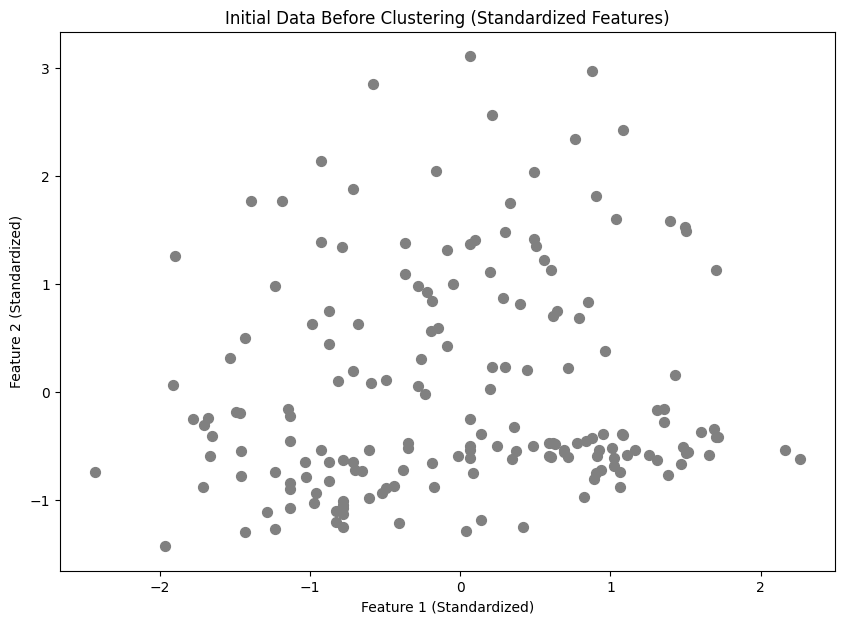

In [6]:
# Plotting the initial data before clustering
plt.figure(figsize=(10, 7))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c='gray', s=50)
plt.title("Initial Data Before Clustering (Standardized Features)")
plt.xlabel("Feature 1 (Standardized)")
plt.ylabel("Feature 2 (Standardized)")
plt.show()

## Performing Agglomerative Hierarchical Clustering

- Computing Distance Matrix
While merging two clusters we check the distance between two every pair of clusters and merge the pair with the least distance/most similarity. But the question is how is that distance determined. There are different ways of defining Inter Cluster distance/similarity. Some of them are:

+ Min Distance: Find the minimum distance between any two points of the cluster.
+ Max Distance: Find the maximum distance between any two points of the cluster.
+ Group Average: Find the average distance between every two points of the clusters.
+ Centroid (Ward’s Method): The similarity of two clusters is based on the increase in squared error when two clusters are merged.

For example, if we group a given data using different methods, we may get different results:

<div><img src="Distance-Matrix-in-Hierarchical--Clustering.png" width="600"</div>

In [7]:
# Step 3: Perform hierarchical clustering
Z = linkage(X_scaled, method='ward')

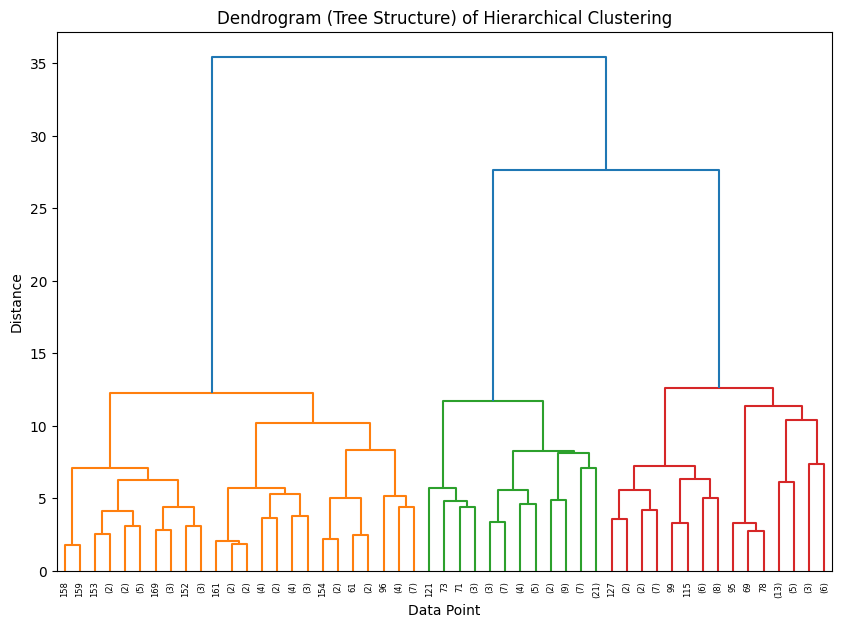

In [8]:
# Step 4: Visualize the dendrogram
plt.figure(figsize=(10, 7))
plt.title("Dendrogram (Tree Structure) of Hierarchical Clustering")
dendrogram(Z, truncate_mode='level', p=5)  # Truncate to show top 5 levels
plt.xlabel("Data Point")
plt.ylabel("Distance")
plt.show()

## What is a Silhouette Score?

Silhouette score measures how similar each data point is to its own cluster (cohesion) compared to other clusters (separation).
The score ranges from -1 to 1:

- +1: The point is well-clustered and far from neighboring clusters.
- 0: The point lies on or very close to the decision boundary between two clusters.
- -1: The point is misclassified and closer to a different cluster than its own.

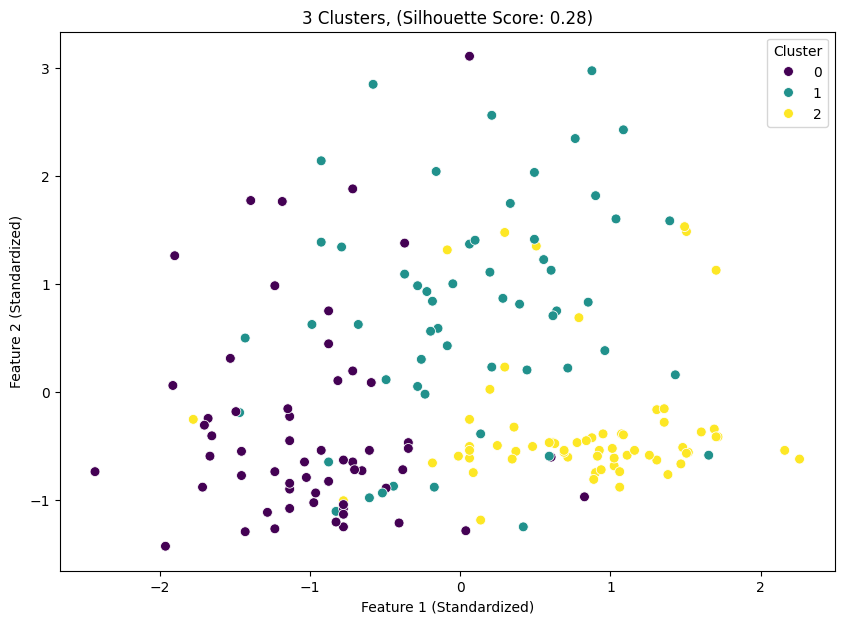

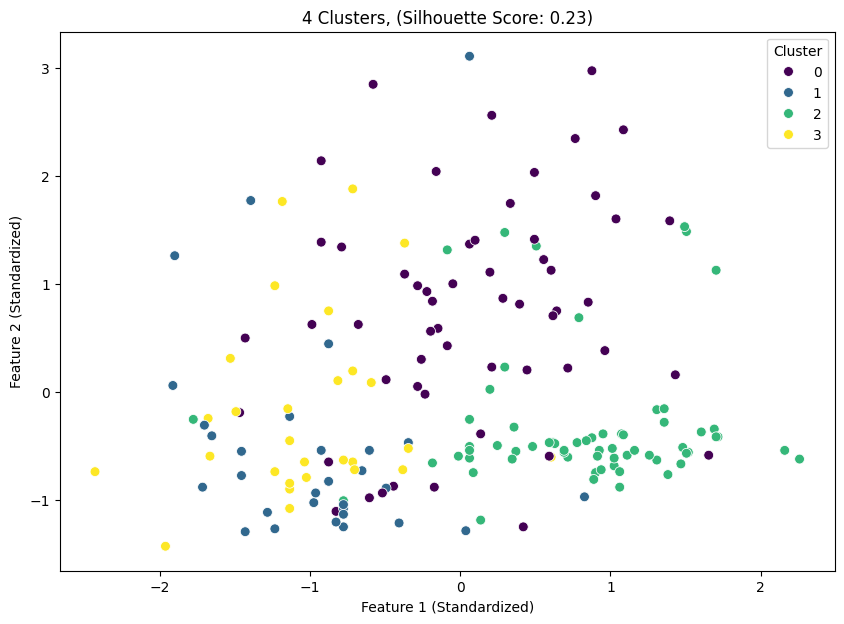

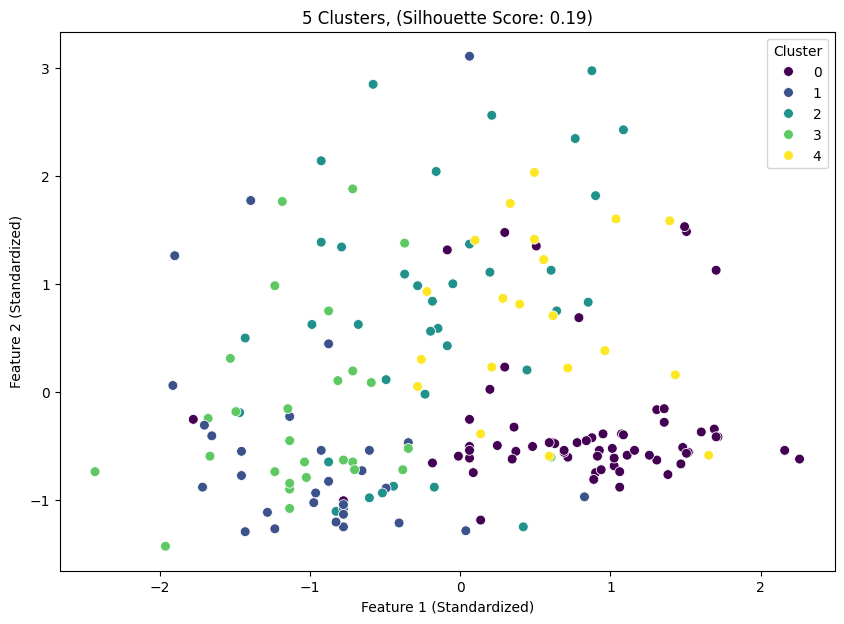

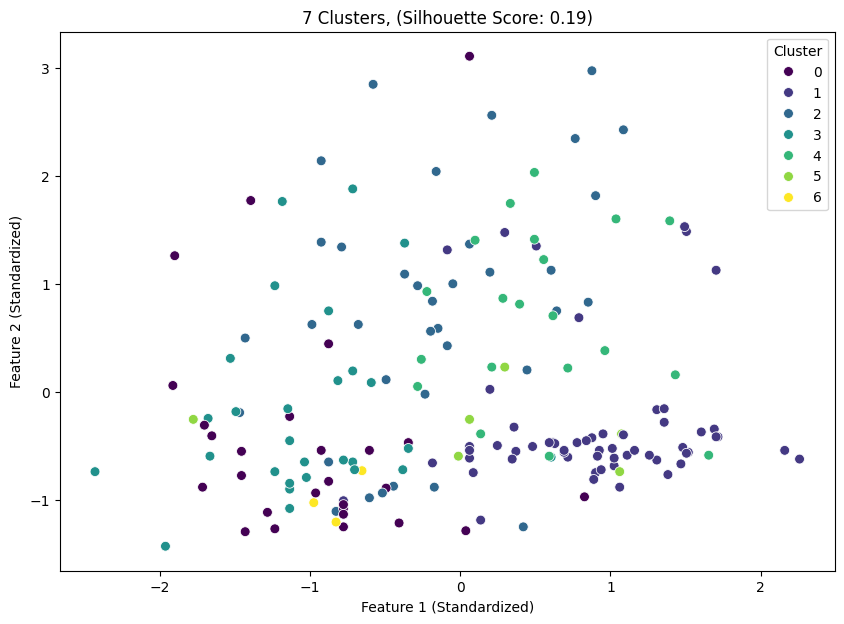

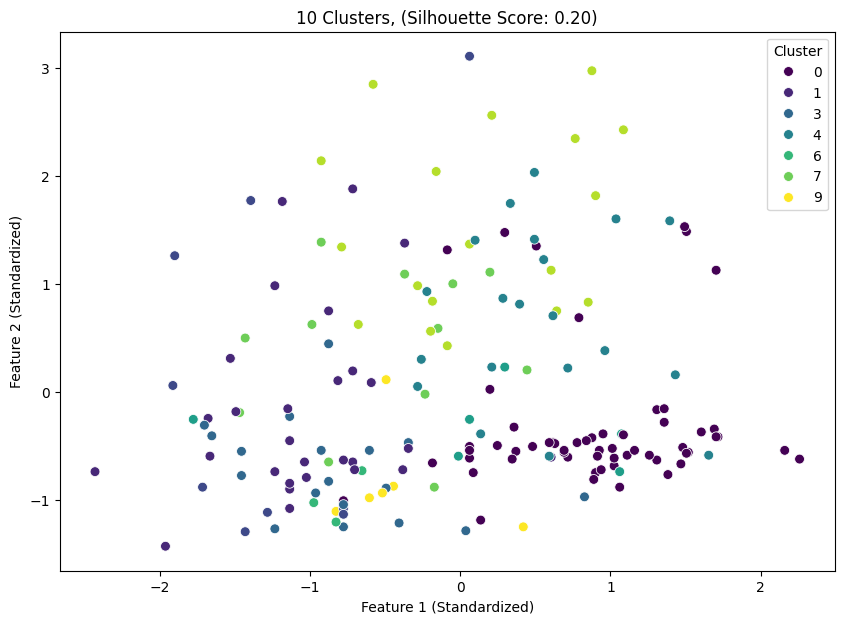

In [9]:
# Step 5: Fit Agglomerative Clustering model and visualize

import seaborn as sns

# Function to plot clusters at different stages
def plot_clusters(cluster, X_scaled):
    # Fit the Agglomerative Clustering model
    agg_clustering = AgglomerativeClustering(n_clusters=cluster, linkage='ward')
    clusters = agg_clustering.fit_predict(X_scaled)
    
    case_score = silhouette_score(X_scaled, clusters)

    # Plot the resulting clusters
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=clusters, palette='viridis', s=50)
    plt.title(f"{cluster} Clusters, (Silhouette Score: {case_score:.2f})")
    plt.xlabel("Feature 1 (Standardized)")
    plt.ylabel("Feature 2 (Standardized)")
    plt.legend(title="Cluster", loc='upper right')
    plt.show()


plot_clusters(3, X_scaled)  # 3 clusters
plot_clusters(4, X_scaled)  # 4 clusters
plot_clusters(5, X_scaled)  # 5 clusters
plot_clusters(7, X_scaled)  # 7 clusters
plot_clusters(10, X_scaled)  # 10 clusters

[0.2670131771272231, 0.2774439826952265, 0.225836659334758, 0.18674235566758707, 0.17966642854438503, 0.18685342560226942, 0.18834697102837825, 0.1917169293227209, 0.19856750165505588]


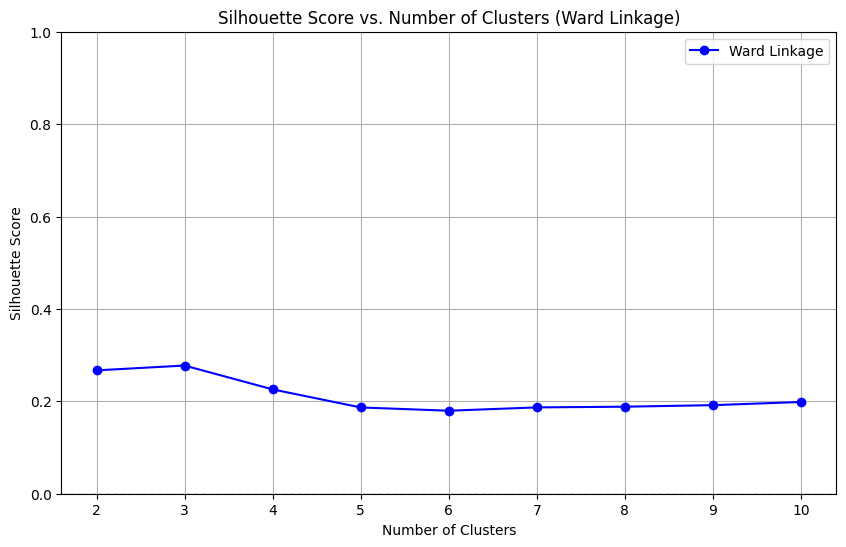

In [10]:
def calculate_silhouette(cluster, X_scaled):
    # Fit the Agglomerative Clustering model
    agg_clustering = AgglomerativeClustering(n_clusters=cluster, linkage='ward')
    clusters = agg_clustering.fit_predict(X_scaled)
    
    case_score = silhouette_score(X_scaled, clusters)
    return case_score

# Number of clusters to analyze
cluster_numbers = range(2, 11)

# Storage for silhouette scores
silhouette_scores = []

# Calculate silhouette scores for different numbers of clusters
for n in cluster_numbers:
    score = calculate_silhouette(n, X_scaled)
    silhouette_scores.append(score)
    
print(silhouette_scores)

# Plotting silhouette scores for Ward linkage
plt.figure(figsize=(10, 6))
plt.plot(cluster_numbers, silhouette_scores, marker='o', color='blue', label='Ward Linkage')
plt.title('Silhouette Score vs. Number of Clusters (Ward Linkage)')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_numbers)
plt.ylim(0, 1)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.legend()
plt.grid()
plt.show()

## Additional analysis between different linkage

In Addition, we also  compare four popular linkage methods in hierarchical clustering—Ward’s, Single Linkage, Complete Linkage, and Average Linkage—and analyze their performance through the measuring silhouette scores.

- Single Linkage: Minimum distance between points in two clusters.
- Complete Linkage: Maximum distance between points in two clusters.
- Average Linkage: Average distance between points in two clusters.
- Centroid/Ward's Linkage: Minimizes the variance within each cluster.

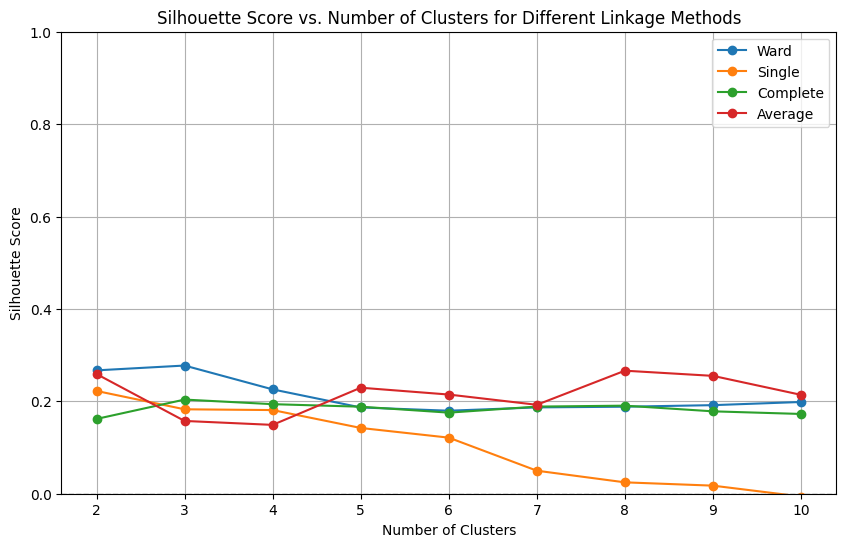

In [11]:
def calculate_silhouette(X, n_clusters, linkage_method):
    # Fit the Agglomerative Clustering model
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage_method)
    clusters = agg_clustering.fit_predict(X)
    
    # Calculate silhouette score
    score = silhouette_score(X, clusters)
    return score

# Number of clusters to analyze
cluster_numbers = range(2, 11)

# Storage for silhouette scores for each linkage method
silhouette_scores = {
    'Ward': [],
    'Single': [],
    'Complete': [],
    'Average': []
}

# Performing clustering for different cluster numbers and linkage methods
for n in cluster_numbers:
    silhouette_scores['Ward'].append(calculate_silhouette(X_scaled, n, 'ward'))
    silhouette_scores['Single'].append(calculate_silhouette(X_scaled, n, 'single'))
    silhouette_scores['Complete'].append(calculate_silhouette(X_scaled, n, 'complete'))
    silhouette_scores['Average'].append(calculate_silhouette(X_scaled, n, 'average'))

# Plotting silhouette scores for different linkage methods
plt.figure(figsize=(10, 6))
for method in silhouette_scores.keys():
    plt.plot(cluster_numbers, silhouette_scores[method], marker='o', label=method)

plt.title('Silhouette Score vs. Number of Clusters for Different Linkage Methods')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_numbers)
plt.ylim(0, 1)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.legend()
plt.grid()
plt.show()

## What Do These Scores Indicate?

- The highest silhouette score is 0.28 for 3 clusters, indicating this might be the best grouping in terms of cohesion and separation.
- The scores for 5, 7, and 10 clusters are all around 0.19-0.20, which suggests that increasing the number of clusters beyond 3 does not improve the clustering quality much. In fact, these numbers might indicate some level of over-partitioning, where the data is being split into clusters that are not as well-separated or meaningful.

## Additional Comparison

- Davies-Bouldin Index (DBI)
Definition: The DBI is a metric used to evaluate the goodness of clustering. It measures the average "similarity ratio" between each cluster and its most similar cluster, with the goal of assessing how well the clusters are separated.


- Calinski-Harabasz Index (CHI)
Definition: The CHI, also known as the Variance Ratio Criterion, evaluates cluster quality based on the ratio of the sum of between-cluster dispersion to within-cluster dispersion.

Clusters: 2 -> Davies-Bouldin Index: 1.412, Calinski-Harabasz Index: 65.361
Clusters: 3 -> Davies-Bouldin Index: 1.419, Calinski-Harabasz Index: 67.647
Clusters: 4 -> Davies-Bouldin Index: 1.789, Calinski-Harabasz Index: 51.464
Clusters: 5 -> Davies-Bouldin Index: 1.923, Calinski-Harabasz Index: 43.679
Clusters: 6 -> Davies-Bouldin Index: 1.812, Calinski-Harabasz Index: 39.129
Clusters: 7 -> Davies-Bouldin Index: 1.662, Calinski-Harabasz Index: 36.291
Clusters: 8 -> Davies-Bouldin Index: 1.551, Calinski-Harabasz Index: 34.021
Clusters: 9 -> Davies-Bouldin Index: 1.545, Calinski-Harabasz Index: 32.460
Clusters: 10 -> Davies-Bouldin Index: 1.476, Calinski-Harabasz Index: 30.537


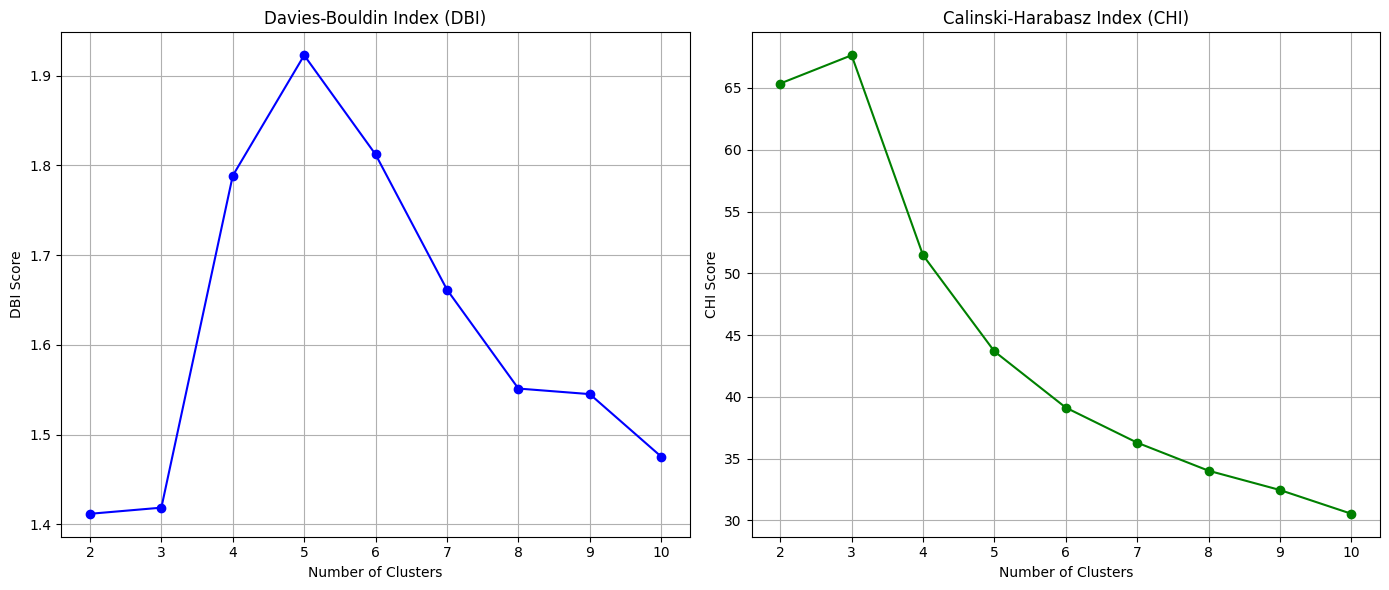

In [12]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

dbi_scores = []
chi_scores = []

for n in cluster_numbers:
    agglomerative_model = AgglomerativeClustering(n_clusters=n)
    cluster_labels = agglomerative_model.fit_predict(X_scaled)
    dbi = davies_bouldin_score(X_scaled, cluster_labels)
    dbi_scores.append(dbi)
    chi = calinski_harabasz_score(X_scaled, cluster_labels)
    chi_scores.append(chi)
    
    
for n_clusters, dbi, chi in zip(cluster_numbers, dbi_scores, chi_scores):
    print(f"Clusters: {n_clusters} -> Davies-Bouldin Index: {dbi:.3f}, Calinski-Harabasz Index: {chi:.3f}")
    

# Plot DBI scores
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(cluster_numbers, dbi_scores, marker='o', color='blue', linestyle='-')
plt.title('Davies-Bouldin Index (DBI)')
plt.xlabel('Number of Clusters')
plt.ylabel('DBI Score')
plt.xticks(cluster_numbers)
plt.grid()

# Plot CHI scores
plt.subplot(1, 2, 2)
plt.plot(cluster_numbers, chi_scores, marker='o', color='green', linestyle='-')
plt.title('Calinski-Harabasz Index (CHI)')
plt.xlabel('Number of Clusters')
plt.ylabel('CHI Score')
plt.xticks(cluster_numbers)
plt.grid()

plt.tight_layout()
plt.show()


- A lower DBI score suggests that the clusters are well-separated and compact, indicating better clustering quality.
- A higher DBI score suggests that the clusters are less distinct from each other, indicating poorer clustering quality.
- A higher CHI score indicates that the clusters are well-separated and compact, indicating better clustering quality.
- A lower CHI score suggests that the clusters are overlapping or poorly separated.

Both of the Index shows that 3 is the optimal number for the cluster.

## Elbow Method Analysis

The Elbow Method can be use to determine the optimal number of clusters by calculating:
- K-Means Inertia: Inertia is the sum of squared distances between data points and their respective centroids.
- Agglomerative Clustering (Ward/Centroid method): The average centroid distances is calculated for different numbers of clusters.

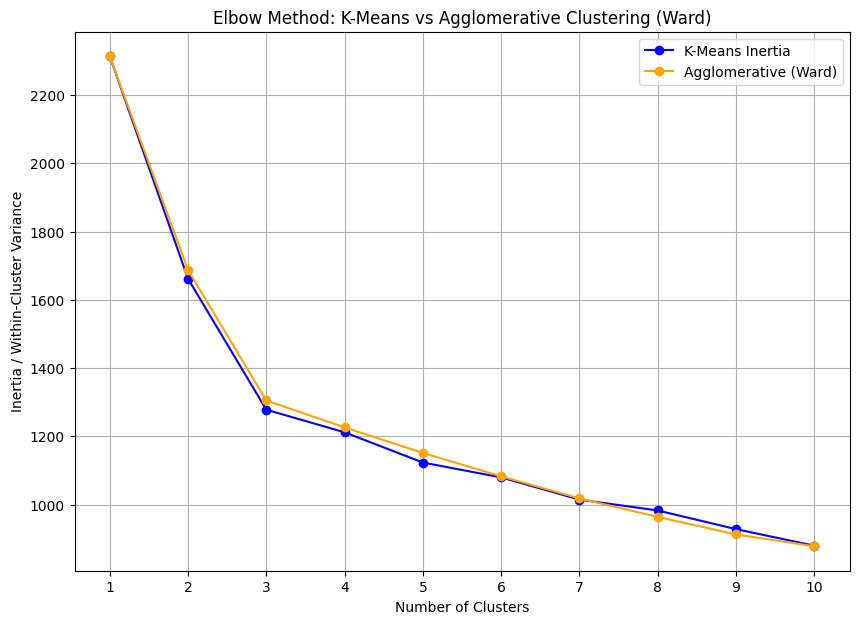

In [13]:
# Function to compute inertia (WCSS) for K-Means
def compute_kmeans_inertia(X_scaled):
    inertias = []
    for n_clusters in range(1, 11):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(X_scaled)
        inertias.append(kmeans.inertia_)
    return inertias

# Compute inertia for K-Means
kmeans_inertias = compute_kmeans_inertia(X_scaled)

# Function to compute within-cluster variance for Agglomerative Clustering (Ward)
def compute_within_cluster_variance_agglom(X_scaled, Z, max_clusters):
    variances = []
    for n_clusters in range(1, max_clusters + 1):
        clusters = fcluster(Z, n_clusters, criterion='maxclust')
        variance = 0
        for cluster in np.unique(clusters):
            cluster_points = X_scaled[clusters == cluster]
            centroid = np.mean(cluster_points, axis=0)
            variance += np.sum((cluster_points - centroid) ** 2)
        variances.append(variance)
    return variances

# Compute within-cluster variance for Agglomerative Clustering (Ward)
agglom_variances = compute_within_cluster_variance_agglom(X_scaled, Z, 10)

# Combined plot for K-Means Inertia and Agglomerative Clustering (Ward)
plt.figure(figsize=(10, 7))

# Plot K-Means inertia
plt.plot(range(1, 11), kmeans_inertias, marker='o', label='K-Means Inertia', color='blue')

# Plot Agglomerative Clustering (Ward) variance
plt.plot(range(1, 11), agglom_variances, marker='o', label='Agglomerative (Ward)', color='orange')

# Ensure all cluster numbers are shown on the x-axis (1 to 10)
plt.xticks(range(1, 11))

# Add labels and title
plt.title('Elbow Method: K-Means vs Agglomerative Clustering (Ward)')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia / Within-Cluster Variance')
plt.grid(True)
plt.legend()
plt.show()

## Additional analysis between different linkage

In Addition, we also  compare four popular linkage methods in hierarchical clustering—Ward’s, Single Linkage, Complete Linkage, and Average Linkage—and analyze their performance through the Elbow Method.

- Single Linkage: Minimum distance between points in two clusters.
- Complete Linkage: Maximum distance between points in two clusters.
- Average Linkage: Average distance between points in two clusters.
- Centroid/Ward's Linkage: Minimizes the variance within each cluster.

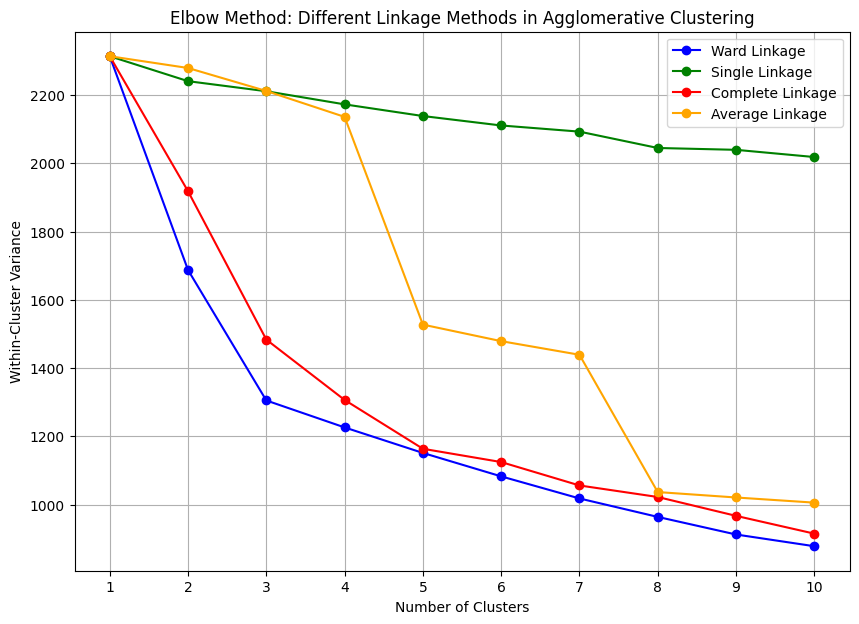

In [14]:
from scipy.cluster.hierarchy import linkage, fcluster

# Function to compute within-cluster variance for Agglomerative Clustering (using different linkage methods)
def compute_within_cluster_variance(X_scaled, linkage_method, max_clusters):
    Z = linkage(X_scaled, method=linkage_method)  # Perform linkage based on method
    variances = []
    for n_clusters in range(1, max_clusters + 1):
        clusters = fcluster(Z, n_clusters, criterion='maxclust')
        variance = 0
        for cluster in np.unique(clusters):
            cluster_points = X_scaled[clusters == cluster]
            centroid = np.mean(cluster_points, axis=0)
            variance += np.sum((cluster_points - centroid) ** 2)
        variances.append(variance)
    return variances

# Compute within-cluster variance for different linkage methods
max_clusters = 10
ward_variances = compute_within_cluster_variance(X_scaled, 'ward', max_clusters)
single_variances = compute_within_cluster_variance(X_scaled, 'single', max_clusters)
complete_variances = compute_within_cluster_variance(X_scaled, 'complete', max_clusters)
average_variances = compute_within_cluster_variance(X_scaled, 'average', max_clusters)

# Combined plot for different linkage methods
plt.figure(figsize=(10, 7))

# Plot for Ward linkage
plt.plot(range(1, max_clusters + 1), ward_variances, marker='o', label='Ward Linkage', color='blue')

# Plot for Single linkage
plt.plot(range(1, max_clusters + 1), single_variances, marker='o', label='Single Linkage', color='green')

# Plot for Complete linkage
plt.plot(range(1, max_clusters + 1), complete_variances, marker='o', label='Complete Linkage', color='red')

# Plot for Average linkage
plt.plot(range(1, max_clusters + 1), average_variances, marker='o', label='Average Linkage', color='orange')

# Ensure all cluster numbers are shown on the x-axis (1 to 10)
plt.xticks(range(1, max_clusters + 1))

# Add labels and title
plt.title('Elbow Method: Different Linkage Methods in Agglomerative Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Variance')
plt.grid(True)
plt.legend()
plt.show()


## Calculate Cluster Means and Variances
To understand the average characteristics of each cluster and how much variation exists within those clusters.

In [15]:
# We choose n_cluster 3
agg_clustering = AgglomerativeClustering(n_clusters=3, linkage='ward')  # Choose the optimal cluster number based on your analysis
wine['Cluster'] = agg_clustering.fit_predict(X_scaled)

# Step 2: Calculate the mean of each feature in each cluster
cluster_means = pd.DataFrame(X_scaled, columns=list(X)) #[f'Feature {i+1}' for i in range(X.shape[1])])
cluster_means['Cluster'] = wine['Cluster']
means = cluster_means.groupby('Cluster').mean()

# Step 3: Calculate variance of each feature across clusters
variances = cluster_means.groupby('Cluster').var()

print("Cluster Means:\n")
display(means)
print("Highest Cluster Means value: ",means.max().idxmax()," with value of ",means[means.max().idxmax()].max() )
print("\nVariances Across Clusters:\n")
display(variances)
print("Highest Variances value: ",variances.max().idxmax()," with value of ",variances[variances.max().idxmax()].max() )


Cluster Means:



,Alcohol,Malicacid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,0D280_0D315_of_diluted_wines,Proline
Cluster,,,,,,,,,,,,,
0,-0.984077,-0.356716,-0.553216,0.214306,-0.504823,-0.051565,0.059067,-0.052449,0.167592,-0.935539,0.449924,0.353896,-0.781673
1,0.075338,0.745293,0.169390,0.453018,0.008115,-0.962723,-1.186099,0.705947,-0.808785,0.775204,-1.037384,-1.249114,-0.388339
2,0.825899,-0.328857,0.353136,-0.590606,0.450396,0.889114,0.984307,-0.570172,0.555807,0.169529,0.499967,0.772256,1.048188


Highest Cluster Means value:  Proline  with value of  1.048187631016354

Variances Across Clusters:



,Alcohol,Malicacid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,0D280_0D315_of_diluted_wines,Proline
Cluster,,,,,,,,,,,,,
0,0.353468,0.869985,1.137897,0.786554,1.205523,0.669091,0.304190,0.853685,1.035681,0.102507,0.819253,0.326570,0.216021
1,0.503589,1.078377,0.530511,0.563158,0.683990,0.340799,0.106746,1.065158,0.548175,1.224765,0.448195,0.173749,0.152080
2,0.476420,0.376073,0.898779,1.043049,0.696795,0.293131,0.219019,0.347339,0.488652,0.294278,0.295995,0.270174,0.684474


Highest Variances value:  Color_intensity  with value of  1.2247654384910662


In [16]:
# Find the maximum mean and minimum variance for each feature
max_means = means.max(axis=0)
min_means = means.min(axis=0)
max_variances = variances.max(axis=0)
min_variances = variances.min(axis=0)

# Create a DataFrame to hold these values
summary_df = pd.DataFrame({
    'Max Mean': max_means,
    'Min Mean': min_means,
    'Max Variance': max_variances, 
    'Min Variance': min_variances
})

# Display the summary DataFrame
print("\nSummary of Max Means and Min Variances for Each Feature:")
display(summary_df)



Summary of Max Means and Min Variances for Each Feature:


,Max Mean,Min Mean,Max Variance,Min Variance
Alcohol,0.825899,-0.984077,0.503589,0.353468
Malicacid,0.745293,-0.356716,1.078377,0.376073
Ash,0.353136,-0.553216,1.137897,0.530511
Alcalinity_of_ash,0.453018,-0.590606,1.043049,0.563158
Magnesium,0.450396,-0.504823,1.205523,0.683990
Total_phenols,0.889114,-0.962723,0.669091,0.293131
Flavanoids,0.984307,-1.186099,0.304190,0.106746
Nonflavanoid_phenols,0.705947,-0.570172,1.065158,0.347339
Proanthocyanins,0.555807,-0.808785,1.035681,0.488652
Color_intensity,0.775204,-0.935539,1.224765,0.102507


## Visualize Feature Distributions by Cluster
To see how each feature is distributed within each cluster, which can reveal insights about the characteristics of different customer segments.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, 'Alcohol'),
  Text(1, 0, 'Malicacid'),
  Text(2, 0, 'Ash'),
  Text(3, 0, 'Alcalinity_of_ash'),
  Text(4, 0, 'Magnesium'),
  Text(5, 0, 'Total_phenols'),
  Text(6, 0, 'Flavanoids'),
  Text(7, 0, 'Nonflavanoid_phenols'),
  Text(8, 0, 'Proanthocyanins'),
  Text(9, 0, 'Color_intensity'),
  Text(10, 0, 'Hue'),
  Text(11, 0, '0D280_0D315_of_diluted_wines'),
  Text(12, 0, 'Proline')])

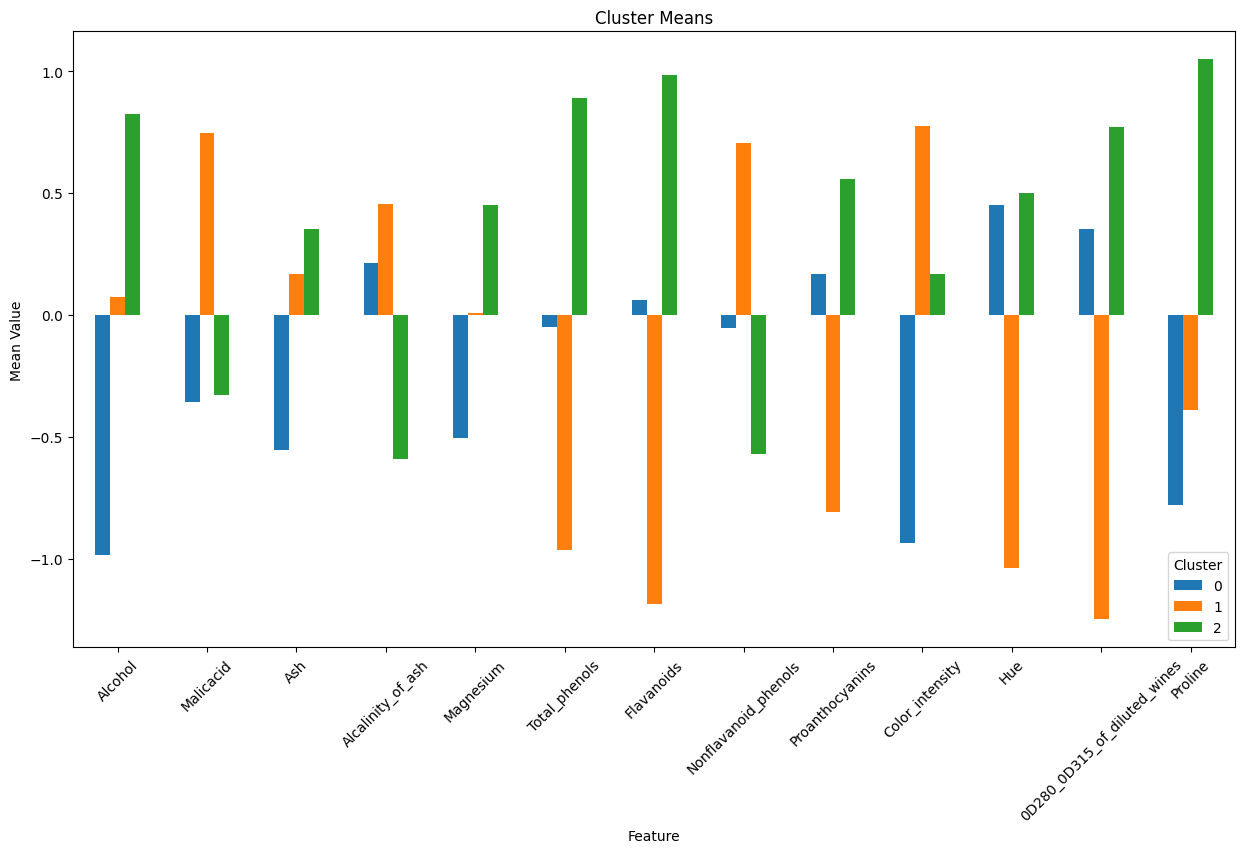

In [17]:


plt.figure(figsize=(15, 8))

# Plot the cluster means for each feature
plt.subplot(1, 1, 1)
means.T.plot(kind='bar', figsize=(15, 8), ax=plt.gca())
plt.title('Cluster Means')
plt.xlabel('Feature')
plt.ylabel('Mean Value')
plt.xticks(rotation=45)


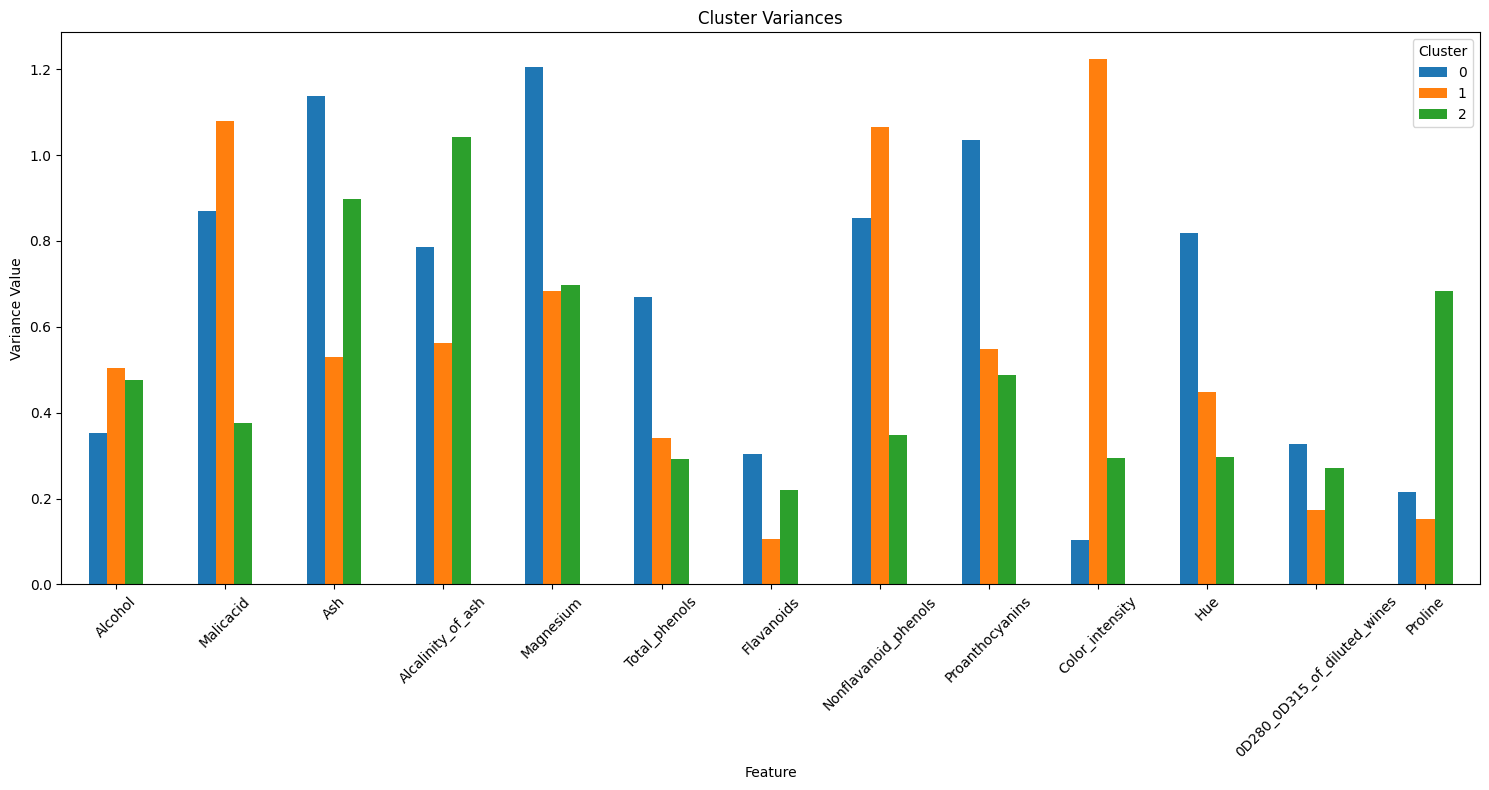

In [18]:

plt.figure(figsize=(15, 8))

# Plot the cluster variances for each feature
plt.subplot(1, 1, 1)
variances.T.plot(kind='bar', figsize=(15, 8), ax=plt.gca())
plt.title('Cluster Variances')
plt.xlabel('Feature')
plt.ylabel('Variance Value')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Conclusion for Presentation:

Steps in experiment involves:

- Loading Data: We loaded the Wine dataset, which contains chemical properties of wines.
Standardization: Standardized the data to give each feature equal importance in the distance calculation.
- Hierarchical Clustering: Performed hierarchical clustering using the Ward method.
- Dendrogram: Explained how to interpret a dendrogram, showing how clusters are merged based on distance.
- Agglomerative Clustering: Specified the number of clusters (3) and fitted the agglomerative clustering model.
- Cluster Visualization: Visualized the resulting clusters based on the first two principal components.
- Calculation of silhouette scores
- Comparison using Elbow point analysis
- Additional analysis between different linkage

## Conclusion for Result and Analysis

In conclusion, from the experiments, we can conclude that the best number of cluster to be 3.
This result is observed from the experiment as
The highest silhouette score is 0.28 for 3 clusters, while scores for 5, 7, and 10 clusters are lower than 0.28, which suggests that increasing the number of clusters beyond 3 does not improve the clustering quality much. In fact, these numbers might indicate some level of over-partitioning, where the data is being split into clusters that are not as well-separated or meaningful.

to confirm this theory, we also analyze it using elbow point methods that conpare number of clusters with its representative average centroids distance.


We calculate means to helps us describe the central tendency of that feature for the data points within the cluster.

<b>Cluster 2 for feature 13 has the highest mean value. ('Proline') </b>

<b>Cluster 1 for feature 12 has the lowest mean value. ('0D280_0D315_of_diluted_wines')</b>

if a cluster has a high mean for alcohol content, you can conclude that wines in this cluster tend to have higher alcohol levels compared to other clusters.


we also calculate variance to measures the spread of the data points within the cluster. 

<b>Feature 10 cluster 0 has the lowest variance ('Color_intensity')</b>

<b>Feauture 10 cluster 1 has the highest variance ('Color_intensity')</b>

A low variance means the points in the cluster are tightly grouped around the mean (homogeneous), whereas a high variance means the data points are more spread out (heterogeneous).
If one cluster has low variance in total phenols, it suggests that most wines in that cluster have a similar phenolic content. If another cluster has high variance, it indicates the wines in that cluster are more diverse in phenolic content.

Through the analysis of within-cluster variances and cluster means, we gained valuable insights into the characteristics of different clusters. Clusters with low variance in certain features indicate homogeneity within those clusters, while high variance points to diversity in that feature among the cluster members.

Feature 10 ('Color_intensity') in Cluster 0 shows low variance, suggesting that members of this cluster have similar values for this feature, making the cluster more uniform in this regard.
Feature 10 ('Color_intensity') in Cluster 1 exhibits high variance, indicating greater diversity in this feature within the cluster.